# Milestone Project : SkimLit 📄🔥

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Download a text Dataset

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 55.10 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [8]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Data Preprocessing (Make Preprocessing Functions to prepare our data for modeling)

In [9]:
def get_lines(filename):
    with open(filename, 'r') as f:
        return f.readlines()
train = get_lines(data_dir+'train.txt')
train[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [17]:
def preprocess_text_with_line_nums(filename):
    lines = get_lines(filename)
    
    abstract_lines = ''
    abstract_samples = []
    
    for line in lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ''
            
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            
            for abstract_line_num, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                
                target_text = abstract_line.split('\t')
                line_data['target_text'] = target_text[0]
                line_data['text'] = target_text[1].lower()
                line_data['line_num'] = abstract_line_num
                line_data['total_lines'] = len(abstract_line_split) - 1
                
                abstract_samples.append(line_data)
                
        else:
                abstract_lines += line
    return abstract_samples

In [19]:
train_data = preprocess_text_with_line_nums(data_dir+'train.txt')
val_data = preprocess_text_with_line_nums(data_dir+'dev.txt')
test_data = preprocess_text_with_line_nums(data_dir+'test.txt')

train_data[:10]

[{'target_text': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_num': 0,
  'total_lines': 11},
 {'target_text': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_num': 1,
  'total_lines': 11},
 {'target_text': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_num': 2,
  'total_lines': 11},
 {'target_text': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_num': 3,
  'total_lines': 11},
 {'target_text': 'METHODS',
  'text': 'secondary outcome measures included the w

In [21]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

train_df.shape, val_df.shape, test_df.shape

((180040, 4), (30212, 4), (30135, 4))

In [22]:
train_df.head()

,target_text,text,line_num,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## Get the input text and target

In [24]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [25]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

train_target_encoder = encoder.fit_transform(train_df['target_text'].to_numpy()) 
val_target_encoder = encoder.fit_transform(val_df['target_text'].to_numpy()) 
test_target_encoder = encoder.fit_transform(test_df['target_text'].to_numpy()) 

train_target_encoder[:5]

array([3, 2, 2, 2, 2])

In [26]:
num_classes = len(encoder.classes_)
classes = encoder.classes_
num_classes, classes

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Setting up a series of modeling experiments

## Model_0 : Multinomial Model

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('MN', MultinomialNB())
])
model_0.fit(train_sentences, train_target_encoder)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('MN', MultinomialNB())])

In [29]:
model_0.score(val_sentences, val_target_encoder)

0.7218323844829869

### get a baseline model metrics results 

In [31]:
# get helper function first
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-10-13 12:48:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-10-13 12:48:06 (35.7 MB/s) - 'helper_functions.py' saved [10246/10246]



In [32]:
from helper_functions import calculate_results
model_0_pred = model_0.predict(val_sentences)
base_line_results = calculate_results(val_target_encoder,
                                     model_0_pred)
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Deep Sequence Models

### Prepare data for deep models

In [35]:
sent_len = [len(sent.split()) for sent in train_sentences]
avg_sent = np.mean(sent_len)
avg_sent

26.338269273494777

In [36]:
max(sent_len)

296

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

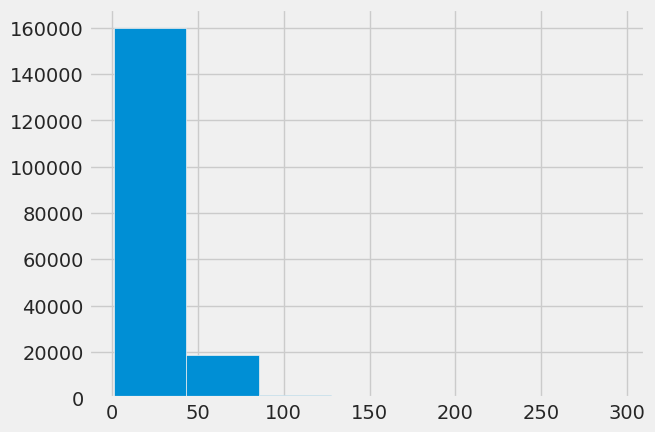

In [38]:
plt.hist(sent_len, bins=7)

In [40]:
np.percentile(sent_len, 98)

68.0

### create a text vectorizer

In [42]:
vocab_size = 68000
vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                              output_sequence_length = 68)
vectorizer.adapt(train_sentences)

In [44]:
# get vocabulary
print(len(vectorizer.get_vocabulary()))
print(vectorizer.get_vocabulary()[:10])
print(vectorizer.get_vocabulary()[-10:])

64841
['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [48]:
import random
target_random_sent = random.choice(train_sentences)
print(target_random_sent)
print(vectorizer([target_random_sent]))
print(vectorizer([target_random_sent]).shape)

preliminary studies have suggested the efficacy of sublingual tablets of house dust mite ( hdm ) extracts in adults with allergic rhinitis .
tf.Tensor(
[[1674  202   99 1161    2   79    4 2854 1603    4 7511 8724 9921 7690
  6295    5  266    7 1892 2640    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 68), dtype=int64)
(1, 68)


### create a custom text embedding

In [50]:
Embedding = tf.keras.layers.Embedding(input_dim = len(vectorizer.get_vocabulary()),
                                     output_dim = 128,
                                     mask_zero = True,
                                     name = 'token_embdding')
print(target_random_sent)
print(Embedding(vectorizer([target_random_sent])))

preliminary studies have suggested the efficacy of sublingual tablets of house dust mite ( hdm ) extracts in adults with allergic rhinitis .
tf.Tensor(
[[[-0.00750331  0.02759082  0.01039835 ... -0.00807376 -0.00919995
   -0.02494385]
  [-0.00198122 -0.01930225 -0.00745856 ...  0.04359814  0.00121322
    0.0098391 ]
  [-0.02270383  0.04063464 -0.0294462  ...  0.01226845 -0.03820267
    0.04121003]
  ...
  [ 0.04707983 -0.01029143  0.00188499 ... -0.02323369  0.04699639
    0.03285906]
  [ 0.04707983 -0.01029143  0.00188499 ... -0.02323369  0.04699639
    0.03285906]
  [ 0.04707983 -0.01029143  0.00188499 ... -0.02323369  0.04699639
    0.03285906]]], shape=(1, 68, 128), dtype=float32)


### Create a dataset using tf.data.Dataset

In [53]:
train_sent_target = tf.data.Dataset.from_tensor_slices((train_sentences, train_target_encoder))
val_sent_target = tf.data.Dataset.from_tensor_slices((val_sentences, val_target_encoder))
test_sent_target = tf.data.Dataset.from_tensor_slices((test_sentences, test_target_encoder))

train_sent_target

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [54]:
train_sent_target = train_sent_target.batch(32).prefetch(tf.data.AUTOTUNE)
val_sent_target = val_sent_target.batch(32).prefetch(tf.data.AUTOTUNE)
test_sent_target = test_sent_target.batch(32).prefetch(tf.data.AUTOTUNE)

train_sent_target

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model 1: Conv1D with token embedding

In [70]:
tf.random.set_seed(123)

model_conv = tf.keras.Sequential([
    layers.Input(shape = [1,], dtype = tf.string, name = 'Input_Layer'),
    vectorizer,
    Embedding,
    layers.Conv1D(64, kernel_size=5, padding="same", activation="relu", name = 'conv1D_layer'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
])
model_conv.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
model_conv.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 68)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embdding (Embedding)      │ (None, 68, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1D_layer (Conv1D)           │ (None, 68, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history_1 = model_conv.fit(
                          train_sent_target,
                          steps_per_epoch = int(0.1 * len(train_sent_target)),
                          epochs = 30,
                          validation_data = val_sent_target,
                          validation_steps = int(0.1 * len(val_sent_target))
                          )

Epoch 1/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6524 - loss: 0.9165 - val_accuracy: 0.7872 - val_loss: 0.5792
Epoch 2/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8158 - loss: 0.5252 - val_accuracy: 0.8015 - val_loss: 0.5507
Epoch 3/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8238 - loss: 0.4950 - val_accuracy: 0.8082 - val_loss: 0.5465
Epoch 4/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8346 - loss: 0.4801 - val_accuracy: 0.8135 - val_loss: 0.5298
Epoch 5/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8361 - loss: 0.4827 - val_accuracy: 0.8088 - val_loss: 0.5390
Epoch 6/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8338 - loss: 0.4781 - val_accuracy: 0.8142 - val_loss: 0.5270
Epoch 7/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8409 - loss: 0.4565 - val_accuracy: 0.8148 - val_loss: 0.5274
Epoch 8/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8459 - loss: 0.4558 - val_accuracy: 0.

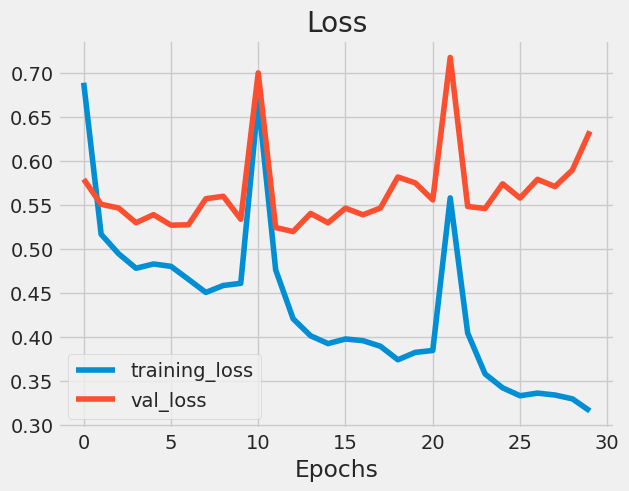

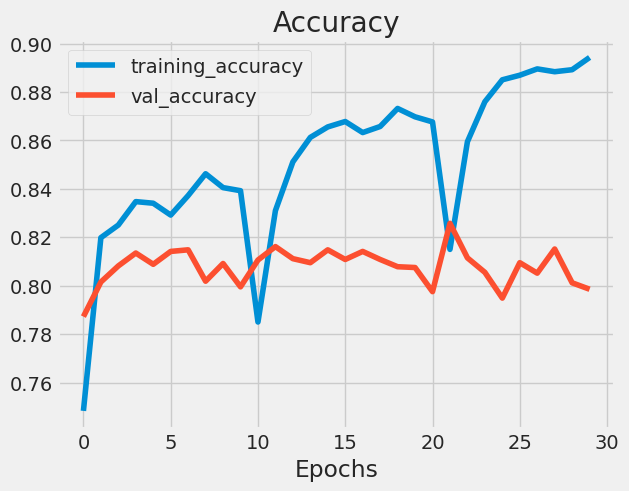

In [72]:
# plot history
from helper_functions import plot_loss_curves
plot_loss_curves(history_1)

In [75]:
# calcualte metrics results of the conv model
model_conv_predict = model_conv.predict(val_sent_target)
model_conv_results = calculate_results(val_target_encoder,
                                      tf.argmax(model_conv_predict, axis = 1))
model_conv_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


{'accuracy': 80.15027141533166,
 'precision': 0.8005713769423798,
 'recall': 0.8015027141533165,
 'f1': 0.800839664832901}

## Model 2: Feature Extraction using pretrained token embedding (Universal Sentence Encoder)

In [88]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = True,
                                        name = "universal_sentence_encoder")

In [89]:
print(target_random_sent)
print(tf_hub_embedding_layer([target_random_sent])[0][:50])
print(tf_hub_embedding_layer([target_random_sent]).shape)

preliminary studies have suggested the efficacy of sublingual tablets of house dust mite ( hdm ) extracts in adults with allergic rhinitis .
tf.Tensor(
[ 0.00319781  0.04794479 -0.05303606 -0.07293328 -0.06683465 -0.00548778
  0.06398918 -0.05960865 -0.00553227  0.05069067  0.0779139   0.04308987
  0.05222387  0.04355742  0.00891205  0.03279153 -0.08125977 -0.02223872
  0.00033316 -0.03742601 -0.06913319  0.02081807 -0.06251808 -0.04796487
 -0.00663875 -0.04394147  0.02258692 -0.03839826  0.01726155 -0.0194848
  0.06426047  0.08011493 -0.01759448  0.01201109 -0.04244988 -0.06673817
 -0.02129238  0.01543733 -0.02622783  0.06854519  0.03600425  0.07479687
 -0.0454397   0.05593673  0.0088676   0.05255546 -0.05729971 -0.01357444
 -0.00438862  0.02792377], shape=(50,), dtype=float32)
(1, 512)


In [95]:
# Build Model
tf.random.set_seed(123)

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = layers.Lambda(lambda x: tf_hub_embedding_layer(x), output_shape = (512,))(inputs)
expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis = 1))(pretrained_embedding)

lstm = layers.Bidirectional(layers.LSTM(128), name = 'bidirection_lstm')(expand_layer)
drop = layers.Dropout(0.25)(lstm)
x = layers.Dense(128, activation="relu")(drop) # add a fully connected layer on top of the embedding
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_use = tf.keras.Model(inputs = inputs,
                        outputs = outputs)

# Compile the model
model_use.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_use.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirection_lstm                │ (None, 256)            │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,925 (2.63 MB)

 Trainable params: 689,925 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# define callbacks and metrics for training the model
checkpoint_path = "USE_Model.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only = True,
    save_weights_only = True,
    monitor = "val_accuracy",
    verbose = 1
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 10, 
    restore_best_weights = True)

CALLBACKS = [early_stopping_callback, checkpoint_callback]

In [98]:
history_2 = model_use.fit(
                          train_sent_target,
                          steps_per_epoch = int(0.1 * len(train_sent_target)),
                          epochs = 30,
                          validation_data = val_sent_target,
                          validation_steps = int(0.1 * len(val_sent_target)),
                          callbacks = CALLBACKS)

Epoch 1/30
558/562 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5823 - loss: 1.0607
Epoch 1: val_accuracy improved from -inf to 0.69082, saving model to USE_Model.weights.h5
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5829 - loss: 1.0593 - val_accuracy: 0.6908 - val_loss: 0.7930
Epoch 2/30
558/562 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7001 - loss: 0.7660
Epoch 2: val_accuracy improved from 0.69082 to 0.71443, saving model to USE_Model.weights.h5
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7001 - loss: 0.7660 - val_accuracy: 0.7144 - val_loss: 0.7462
Epoch 3/30
558/562 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7102 - loss: 0.7502
Epoch 3: val_accuracy improved from 0.71443 to 0.72340, saving model to USE_Model.weights.h5
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7102 - loss: 0.7502 - val_accuracy: 0.7234 - val_loss: 0.7141
Epoch 4/30
559/562 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7255 - loss: 0.7133
Epoch 4: val_accuracy

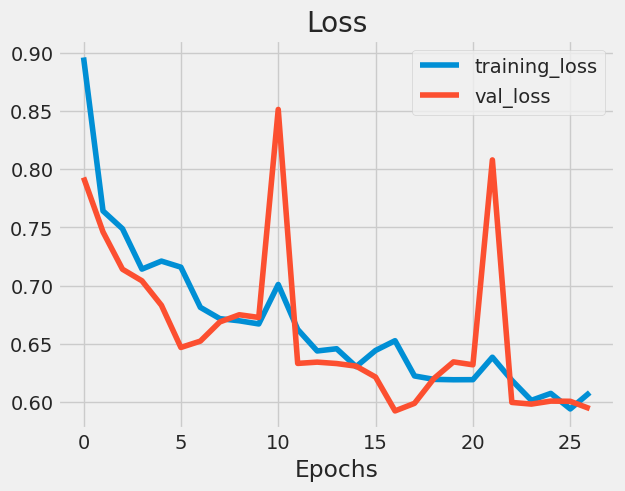

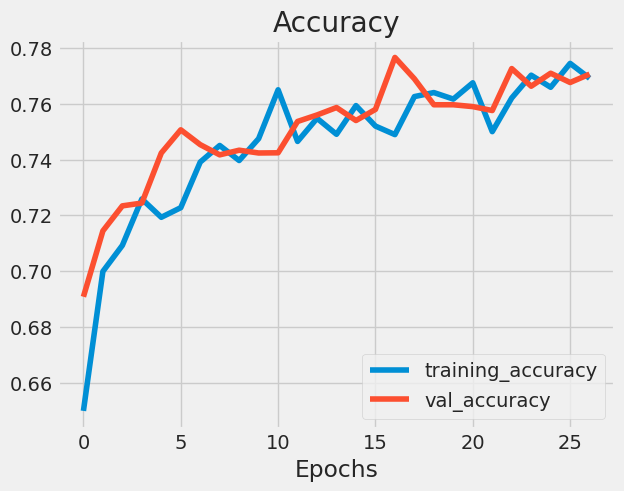

In [99]:
# plot history
from helper_functions import plot_loss_curves
plot_loss_curves(history_2)

In [100]:
# calcualte metrics results of the Use model
model_use_predict = model_use.predict(val_sent_target)
model_use_results = calculate_results(val_target_encoder,
                                      tf.argmax(model_use_predict, axis = 1))
model_use_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step


{'accuracy': 76.57222295776512,
 'precision': 0.7636787859452047,
 'recall': 0.7657222295776512,
 'f1': 0.7624999569946876}

## Model 3: Compining Pretrained token embeddings + charcter embeddings

### Creating a charcter level vectorizer

In [101]:
def split_chars(text):
    return " ".join(list(text))
split_chars(target_random_sent)

'p r e l i m i n a r y   s t u d i e s   h a v e   s u g g e s t e d   t h e   e f f i c a c y   o f   s u b l i n g u a l   t a b l e t s   o f   h o u s e   d u s t   m i t e   (   h d m   )   e x t r a c t s   i n   a d u l t s   w i t h   a l l e r g i c   r h i n i t i s   .'

In [102]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [103]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

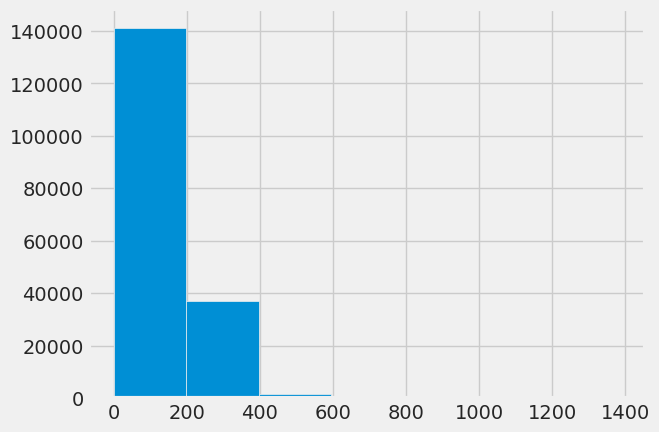

In [104]:
plt.hist(char_lens, bins = 7)

In [106]:
int(np.percentile(char_lens, 98))

347

In [108]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [109]:
# Create char-level token vectorizer instance
num_char_tokens = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=num_char_tokens,  
                                    output_sequence_length = 347,
                                    standardize = "lower_and_strip_punctuation",
                                    name = "char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [114]:
num_char_tokens

70

In [111]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(len(char_vocab))
print(char_vocab[:5])
print(char_vocab[-5:])

28
['', '[UNK]', 'e', 't', 'i']
['k', 'x', 'z', 'q', 'j']


In [113]:
random_train_chars = random.choice(train_chars)

print(random_train_chars)
print(char_vectorizer([random_train_chars]))

o c   k n o w l e d g e   ,   w h i c h   w a s   l o w   a m o n g   y o u n g   w o m e n   i n   o u r   s t u d y   ,   w a s   a s s o c i a t e d   w i t h   o c   c o n t i n u a t i o n   a n d   c o m m o n   r e a s o n s   f o r   d i s c o n t i n u a t i o n   .
tf.Tensor(
[[ 7 11 23  6  7 20 12  2 10 18  2 20 13  4 11 13 20  5  9 12  7 20  5 15
   7  6 18 19  7 16  6 18 20  7 15  2  6  4  6  7 16  8  9  3 16 10 19 20
   5  9  5  9  9  7 11  4  5  3  2 10 20  4  3 13  7 11 11  7  6  3  4  6
  16  5  3  4  7  6  5  6 10 11  7 15 15  7  6  8  2  5  9  7  6  9 17  7
   8 10  4  9 11  7  6  3  4  6 16  5  3  4  7  6  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Creating a charcter level embedding

In [115]:
char_embed = layers.Embedding(input_dim = num_char_tokens, # number of different characters
                              output_dim = 25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero = False, # don't use masks (this messes up model_5 if set to True)
                              name = "char_embed")
print(random_train_chars)
print(char_embed(char_vectorizer([random_train_chars])))

o c   k n o w l e d g e   ,   w h i c h   w a s   l o w   a m o n g   y o u n g   w o m e n   i n   o u r   s t u d y   ,   w a s   a s s o c i a t e d   w i t h   o c   c o n t i n u a t i o n   a n d   c o m m o n   r e a s o n s   f o r   d i s c o n t i n u a t i o n   .
tf.Tensor(
[[[ 0.02517721 -0.04322992  0.01193622 ...  0.03320276 -0.01730375
    0.02634913]
  [ 0.03703037 -0.03133266  0.03677518 ... -0.02728639 -0.00867324
   -0.01753245]
  [-0.03172936  0.00037088  0.00788721 ... -0.04742759 -0.04511113
   -0.03274772]
  ...
  [-0.0264785   0.03960306 -0.04961833 ... -0.02188963  0.00764272
   -0.01021801]
  [-0.0264785   0.03960306 -0.04961833 ... -0.02188963  0.00764272
   -0.01021801]
  [-0.0264785   0.03960306 -0.04961833 ... -0.02188963  0.00764272
   -0.01021801]]], shape=(1, 347, 25), dtype=float32)


### Build Model

In [118]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name = "token_input")
token_embeddings = layers.Lambda(lambda x: tf_hub_embedding_layer(x), output_shape = (512,))(token_inputs)
expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis = 1))(token_embeddings)
lstm = layers.Bidirectional(layers.LSTM(128), name = 'bidirection_lstm')(expand_layer)
drop = layers.Dropout(0.25)(lstm)
token_output = layers.Dense(128, activation="relu")(drop)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_token_and_char_embeddings")
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 512)       │          0 │ token_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 1, 512)    │          0 │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirection_lstm    │ (None, 256)       │    656,384 │ lambda_9[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 347)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ bidirection_lstm… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 347, 25)   │      1,750 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50)        │     10,200 │ char_embed[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 178)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 178)       │          0 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 200)       │     35,800 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 200)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 5)         │      1,005 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 738,035 (2.82 MB)

 Trainable params: 738,035 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

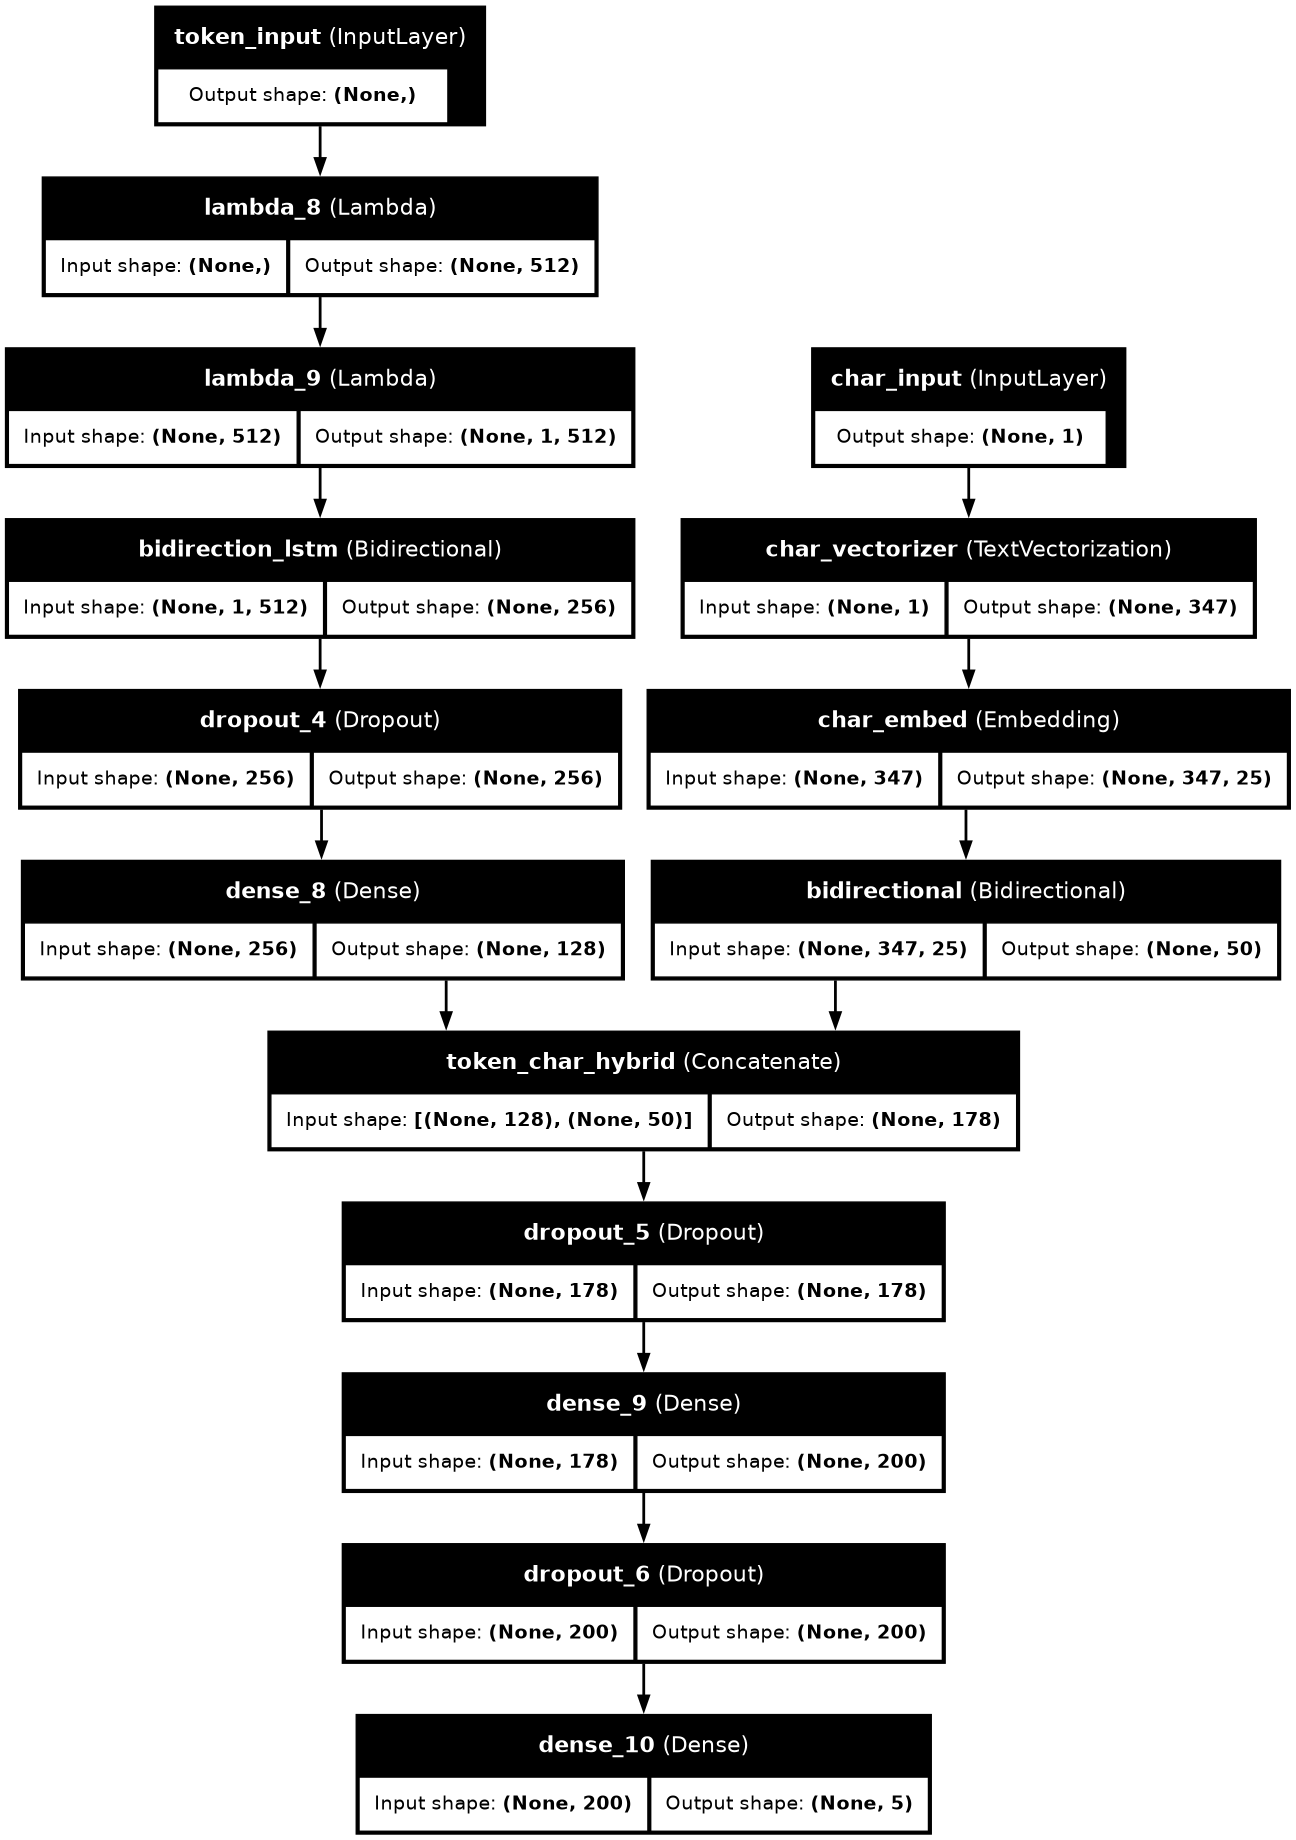

In [124]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes = True, show_layer_names = True, dpi = 100)

In [125]:
model_4.compile(loss = 'sparse_categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [126]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_target_encoder) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_target_encoder)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [127]:
# define callbacks and metrics for training the model
checkpoint_path = "model_4.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only = True,
    save_weights_only = True,
    monitor = "val_accuracy",
    verbose = 1
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 10, 
    restore_best_weights = True)

CALLBACKS = [early_stopping_callback, checkpoint_callback]

In [128]:
history_4 = model_4.fit(
                          train_char_token_dataset,
                          steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                          epochs = 30,
                          validation_data = val_char_token_dataset,
                          validation_steps = int(0.1 * len(val_char_token_dataset)),
                          callbacks = CALLBACKS)

Epoch 1/30
561/562 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5326 - loss: 1.1299
Epoch 1: val_accuracy improved from -inf to 0.68617, saving model to model_4.weights.h5
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5328 - loss: 1.1293 - val_accuracy: 0.6862 - val_loss: 0.8108
Epoch 2/30
561/562 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6916 - loss: 0.8133
Epoch 2: val_accuracy improved from 0.68617 to 0.72008, saving model to model_4.weights.h5
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.6916 - loss: 0.8132 - val_accuracy: 0.7201 - val_loss: 0.7358
Epoch 3/30
561/562 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6977 - loss: 0.7824
Epoch 3: val_accuracy improved from 0.72008 to 0.73537, saving model to model_4.weights.h5
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.6977 - loss: 0.7824 - val_accuracy: 0.7354 - val_loss: 0.7006
Epoch 4/30
561/562 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7136 - loss: 0.7461
Epoch 4: val_accuracy did

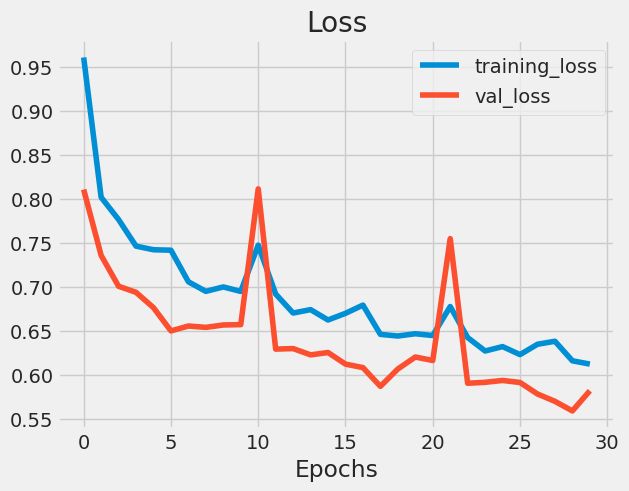

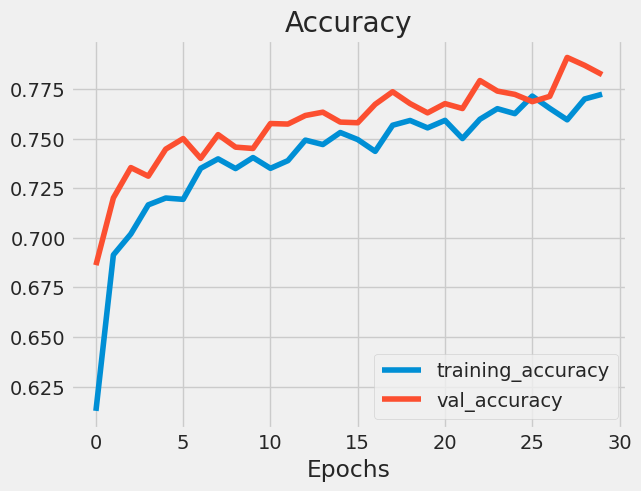

In [129]:
# plot history
from helper_functions import plot_loss_curves
plot_loss_curves(history_4)

In [130]:
# calcualte metrics results of the Use model
model_4_predict = model_4.predict(val_char_token_dataset)
model_4_results = calculate_results(val_target_encoder,
                                      tf.argmax(model_4_predict, axis = 1))
model_4_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step


{'accuracy': 77.66450417052828,
 'precision': 0.7821043036024611,
 'recall': 0.7766450417052827,
 'f1': 0.7755420640454712}

## Model 4: Transfer Learning with Pretrained token embeddings + charcter embeddings + (positional embedding)

### Create a Positional Embeddings

Since our `"line_number"` and `"total_line"` columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with `"line_number"=5` is five times greater than a line with `"line_number"=1`, we'll use one-hot-encoding to encode our `"line_number"` and `"total_lines"` features.

<Axes: ylabel='Frequency'>

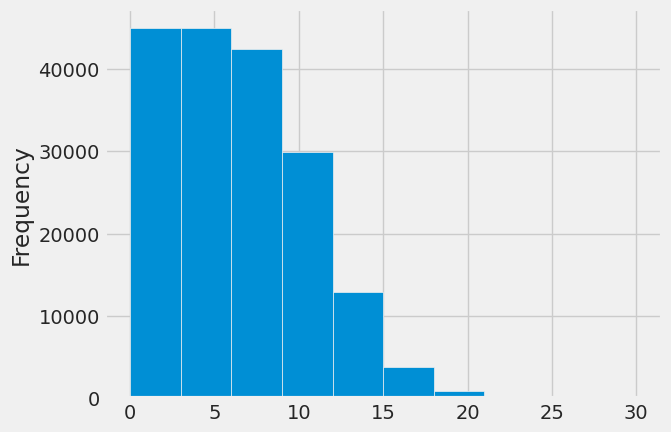

In [131]:
train_df.line_num.plot.hist()

In [132]:
np.percentile(train_df.line_num, 98)

15.0

<Axes: ylabel='Frequency'>

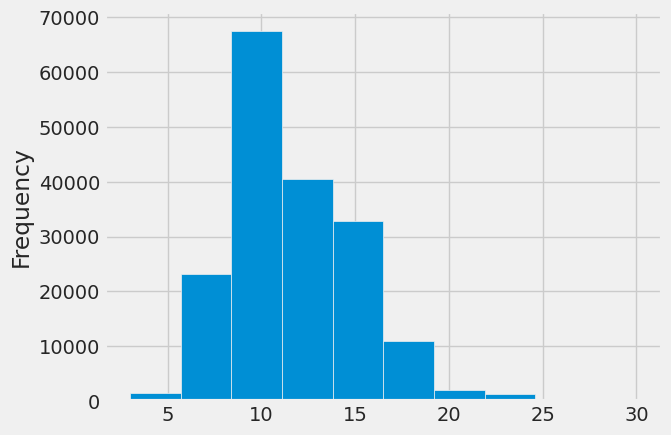

In [133]:
train_df.total_lines.plot.hist()

In [134]:
np.percentile(train_df.total_lines, 98)

20.0

In [136]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_num" column  and "total_lines"
train_line_numbers_one_hot = tf.one_hot(train_df["line_num"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_num"].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_num"].to_numpy(), depth = 15)

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)

train_line_numbers_one_hot.shape, train_total_lines_one_hot.shape

(TensorShape([180040, 15]), TensorShape([180040, 20]))

### Building a tribrid embedding model

In [137]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embeddings = layers.Lambda(lambda x: tf_hub_embedding_layer(x), output_shape = (512,))(token_inputs)
expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis = 1))(token_embeddings)
lstm = layers.Bidirectional(layers.LSTM(128), name = 'bidirection_lstm')(expand_layer)
drop = layers.Dropout(0.25)(lstm)
token_output = layers.Dense(128, activation = "relu")(drop)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape = (15,), dtype = tf.int32, name = "line_number_input")
x = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.int32, name = "total_lines_input")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs = y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name = "token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation = "softmax", name = "output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs = output_layer)

In [138]:
model_5.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 512)       │          0 │ token_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 1, 512)    │          0 │ lambda_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirection_lstm    │ (None, 256)       │    656,384 │ lambda_11[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 347)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ bidirection_lstm… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 347, 25)   │      1,750 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     32,896 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50)        │     10,200 │ char_embed[1][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid_… │ (None, 178)       │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │     45,824 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_positio… │ (None, 320)       │          0 │ dense_12[0][0],   │
│ (Concatenate)       │                   │            │ dense_13[0][0],   │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ token_char_posit… │
│ (Dense)             │                   │            │                 

 Total params: 749,843 (2.86 MB)

 Trainable params: 749,843 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

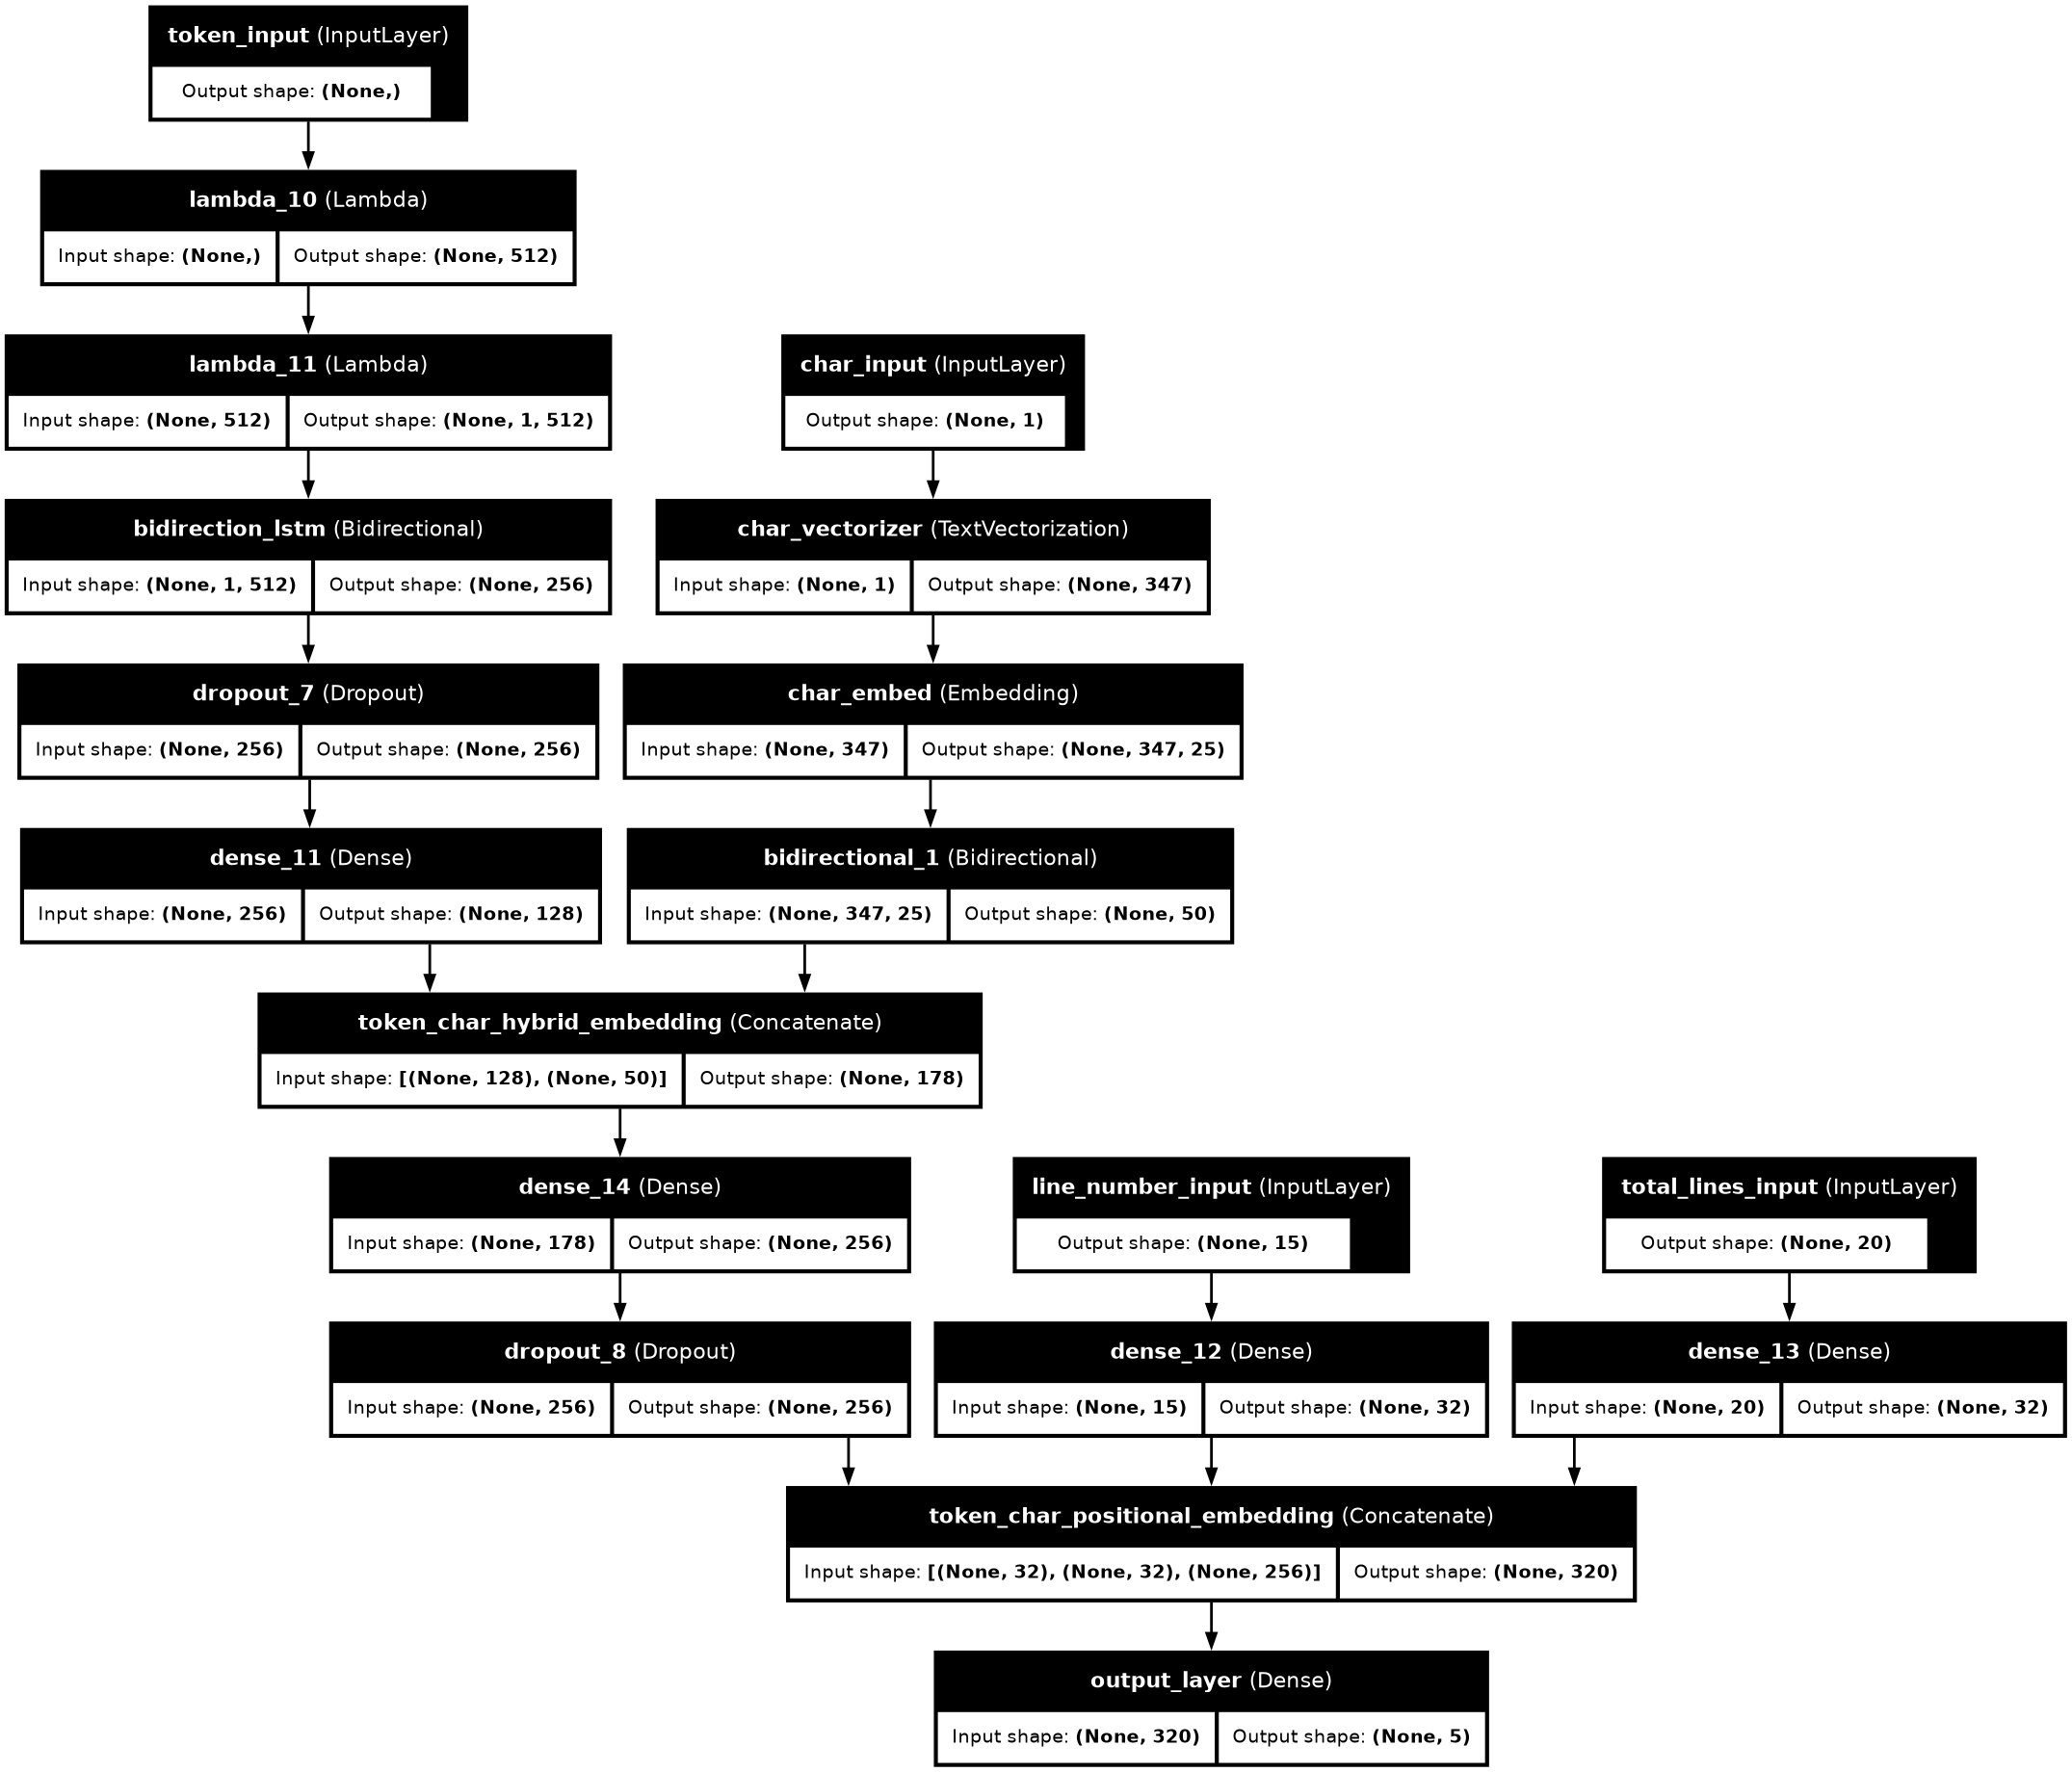

In [140]:
# Plot tribrid model
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes = True, show_layer_names = True, dpi = 100)

In [141]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<InputLayer name=token_input, built=True> True
<Lambda name=lambda_10, built=True> True
<Lambda name=lambda_11, built=True> True
<InputLayer name=char_input, built=True> True
<Bidirectional name=bidirection_lstm, built=True> True
<TextVectorization name=char_vectorizer, built=True> True
<Dropout name=dropout_7, built=True> True
<Embedding name=char_embed, built=True> True
<Dense name=dense_11, built=True> True
<Bidirectional name=bidirectional_1, built=True> True
<Concatenate name=token_char_hybrid_embedding, built=True> True
<InputLayer name=line_number_input, built=True> True
<InputLayer name=total_lines_input, built=True> True
<Dense name=dense_14, built=True> True
<Dense name=dense_12, built=True> True
<Dense name=dense_13, built=True> True
<Dropout name=dropout_8, built=True> True
<Concatenate name=token_char_positional_embedding, built=True> True
<Dense name=output_layer, built=True> True


In [142]:
model_5.compile(loss = 'sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [143]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_target_encoder) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) 

# combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_target_encoder)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))

val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# test dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_target_encoder)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))

test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset, test_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [144]:
# define callbacks and metrics for training the model
checkpoint_path = "model_5.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only = True,
    save_weights_only = True,
    monitor = "val_accuracy",
    verbose = 1
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 10, 
    restore_best_weights = True)

CALLBACKS = [early_stopping_callback, checkpoint_callback]

In [145]:
history_5 = model_5.fit(
                          train_pos_char_token_dataset,
                          steps_per_epoch = int(0.1 * len(train_pos_char_token_dataset)),
                          epochs = 50,
                          validation_data = val_pos_char_token_dataset,
                          validation_steps = int(0.1 * len(val_pos_char_token_dataset)),
                          callbacks = CALLBACKS)

Epoch 1/50
561/562 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5910 - loss: 1.0109
Epoch 1: val_accuracy improved from -inf to 0.78524, saving model to model_5.weights.h5
562/562 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.5914 - loss: 1.0100 - val_accuracy: 0.7852 - val_loss: 0.5639
Epoch 2/50
561/562 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8020 - loss: 0.5307
Epoch 2: val_accuracy improved from 0.78524 to 0.80685, saving model to model_5.weights.h5
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8020 - loss: 0.5306 - val_accuracy: 0.8068 - val_loss: 0.4787
Epoch 3/50
561/562 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8046 - loss: 0.4984
Epoch 3: val_accuracy improved from 0.80685 to 0.81782, saving model to model_5.weights.h5
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8046 - loss: 0.4983 - val_accuracy: 0.8178 - val_loss: 0.4505
Epoch 4/50
561/562 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8224 - loss: 0.4592
Epoch 4: val_accuracy imp

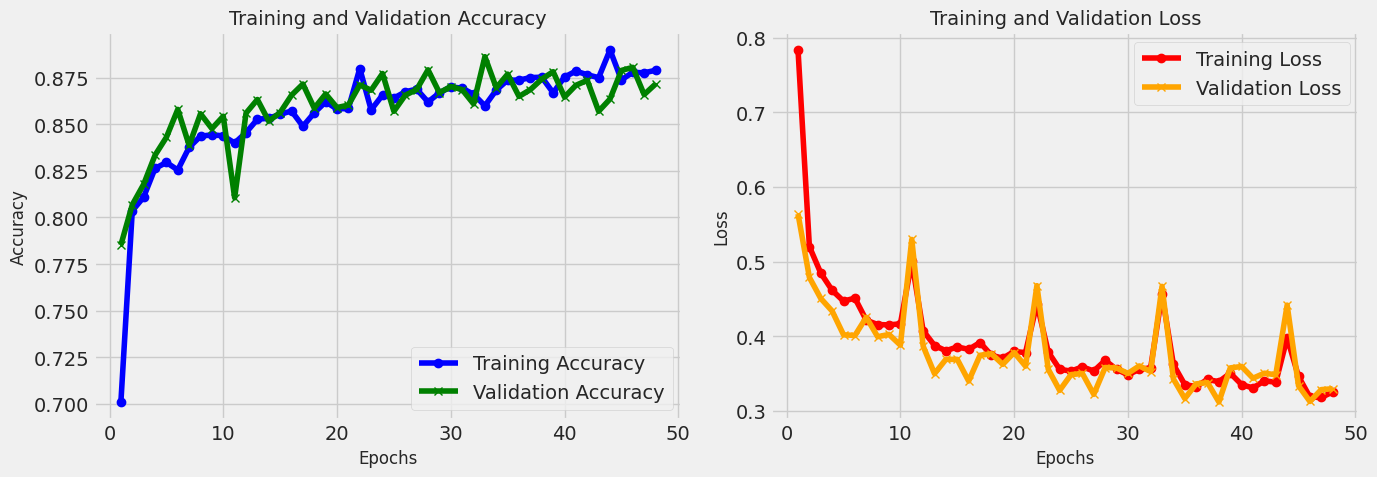

In [148]:
# Extracting the history data
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']
epochs = range(1, len(acc) + 1)

# Create a figure with 2 subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotting Accuracy
ax1.plot(epochs, acc, label='Training Accuracy', color='blue', marker='o')
ax1.plot(epochs, val_acc, label='Validation Accuracy', color='green', marker='x')
ax1.set_title('Training and Validation Accuracy', fontsize=14)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()

# Plotting Loss
ax2.plot(epochs, loss, label='Training Loss', color='red', marker='o')
ax2.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='x')
ax2.set_title('Training and Validation Loss', fontsize=14)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()

# Adjust layout for aesthetics
plt.tight_layout()

# Show the plot
plt.show()

In [147]:
# calcualte metrics results of the Use model
model_5.load_weights('/kaggle/working/model_5.weights.h5')
model_5_predict = model_5.predict(val_pos_char_token_dataset)
model_5_results = calculate_results(val_target_encoder,
                                      tf.argmax(model_5_predict, axis = 1))
model_5_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step


{'accuracy': 86.63775983053091,
 'precision': 0.8690014094361697,
 'recall': 0.8663775983053091,
 'f1': 0.8638378289808728}

# Models Evaluation

## Compare Model Results

In [149]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": base_line_results,
                                  "custom_token_embed_conv1d": model_conv_results,
                                  "pretrained_token_embed": model_use_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,80.150271,0.800571,0.801503,0.800840
pretrained_token_embed,76.572223,0.763679,0.765722,0.762500
hybrid_char_token_embed,77.664504,0.782104,0.776645,0.775542
tribrid_pos_char_token_embed,86.637760,0.869001,0.866378,0.863838


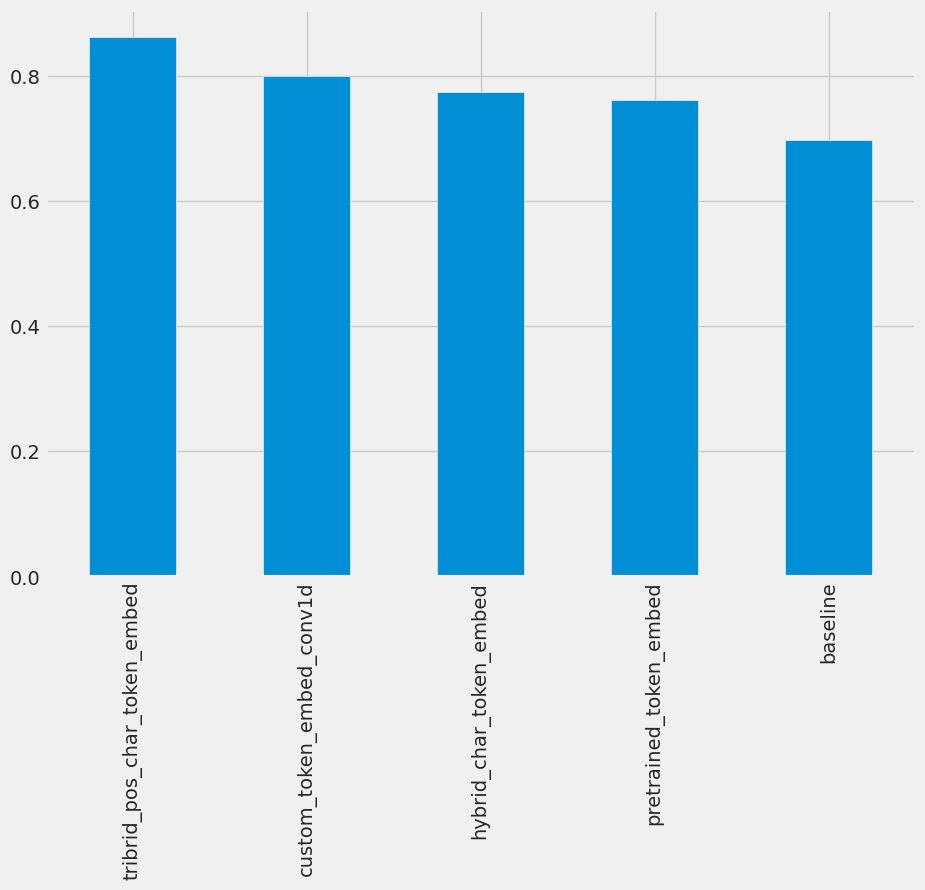

In [150]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.sort_values("f1", ascending = False)["f1"].plot(kind = "bar", figsize=(10, 7));

# Making Predictions

In [151]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose = 1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [152]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true = test_target_encoder,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 85.98639455782313,
 'precision': 0.8607633378280585,
 'recall': 0.8598639455782313,
 'f1': 0.8570286755102907}

### Make example predictions

In [153]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-10-13 17:11:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: 'skimlit_example_abstracts.json'

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-10-13 17:11:57 (66.6 MB/s) - 'skimlit_example_abstracts.json' saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [154]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [155]:
# we'll need to parse it using spaCy to turn it from a big chunk of text into sentences.
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"]) 
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [156]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [158]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 

test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

In [159]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

In [160]:
test_abstract_pred_probs = model_5.predict(x = (test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step


<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [161]:
test_abstract_pred_classes = [encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [162]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


In [164]:
import pickle 

with open('encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

![](https://camo.githubusercontent.com/1ae760a72d7f3e2346207f9a0c97a4f645e89254fc50b4c606a450addfcaac30/68747470733a2f2f692e706f7374696d672e63632f74346233577443792f313030302d462d3239313532323230352d586b726d2d533432312d466a2d5347544d522e6a7067)